This version, we use national marketshare data, and applied this data to our research area
Also consider population in the buffer zone
calculate the MARKETSHARE

In [1]:
'''
Description: Notebook for cleaning and processing the buffer and doctor data
Version: 1.0
Autor: 
Date: 2021-07-07 18:14:01
LastEditors: 
LastEditTime: 2021-11-04 14:55:07
'''


'\nDescription: Notebook for cleaning and processing the buffer and doctor data\nVersion: 1.0\nAutor: Yaxiong Shao\nDate: 2021-07-07 18:14:01\nLastEditors: Yaxiong Shao\nLastEditTime: 2021-11-04 14:55:07\n'

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# 1. Make buffer for CookCounty

### 1.1 create a buffer zone from cook county

<AxesSubplot:>

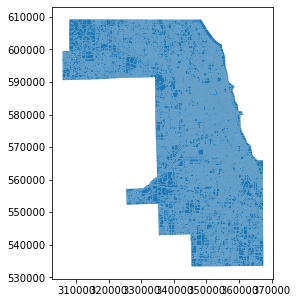

In [2]:
#read cook county shapefile and US shapefile
Cook_Boundaries_gdf = gpd.read_file('Census2010/CookCountyBlocks/Blocks.shp')
#project these two shapefiles
Cook_Boundaries_gdf_prj= Cook_Boundaries_gdf.to_crs('EPSG:26971')
fig,ax=plt.subplots(figsize=(5,5))
Cook_Boundaries_gdf_prj.plot(ax=ax)

<AxesSubplot:>

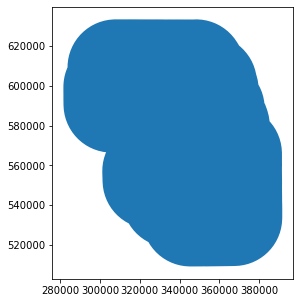

In [3]:
#make buffer for cook
Cook_Boundaries2010_Buffer_gdf=gpd.GeoDataFrame()
#Cook_Boundaries2010_Buffer_gdf['geometry']=Cook_Boundaries_gdf_prj.geometry.buffer(32186.9)#20mi
Cook_Boundaries2010_Buffer_gdf['geometry']=Cook_Boundaries_gdf_prj.geometry.buffer(24140.2)#15mi

#Merge all polygon into one
Cook_Boundaries2010_Buffer_gdf['new_column'] = 0
Cook_Boundaries2010_Buffer_gdf = Cook_Boundaries2010_Buffer_gdf.dissolve(by='new_column')
#plot results
fig,ax=plt.subplots(figsize=(5,5))
Cook_Boundaries2010_Buffer_gdf.plot(ax=ax)

In [4]:
Cook_Boundaries2010_Buffer_gdf.crs = ('epsg:26971')
#Cook_Boundaries2010_Buffer_gdf.to_file(driver = 'ESRI Shapefile', filename= "Cook_Boundaries2010_Buffer_polygon_15mi.shp")

### 1.2 Merge Block files and cut the areas in the buffer

In [5]:
#merge three censu blocks into one
IL_CensusBlocks_2010_gdf = gpd.read_file('Census2010/IL_Block10/IL_Block10.shp')
IN_CensusBlocks_2010_gdf = gpd.read_file('Census2010/IN_Block10/IN_Block10.shp')
WI_CensusBlocks_2010_gdf = gpd.read_file('Census2010/WI_Block10/WI_Block10.shp')
merged_gdf = gpd.GeoDataFrame(pd.concat( [IL_CensusBlocks_2010_gdf,IN_CensusBlocks_2010_gdf,WI_CensusBlocks_2010_gdf], ignore_index=True) )
merged_gdf.shape

(971721, 16)

<AxesSubplot:>

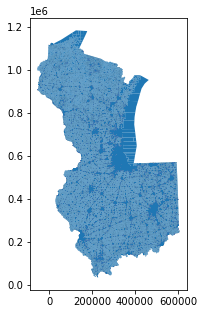

In [6]:
#project the merged data
fig,ax=plt.subplots(figsize=(5,5))
merged_gdf.crs = ('epsg:4326')
merged_gdf_prj = merged_gdf.to_crs('EPSG:26971')
merged_gdf_prj.plot(ax=ax)

/Users/yaxiongshao/opt/miniconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

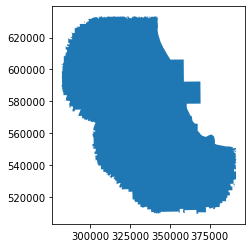

In [7]:
#get the buffer for merged census blocks
Cook_Boundaries2010_Buffer_polygon=Cook_Boundaries2010_Buffer_gdf.geometry[0]
Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf = merged_gdf_prj[merged_gdf_prj.within(Cook_Boundaries2010_Buffer_polygon)]
#Merge all polygon into one
Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf['new_column'] = 0
Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf = Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf.dissolve(by='new_column')

Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf.plot()

# 2. Select Doctors in the Buffer 

### 2.1 Read doctor data and reproject the data

In [9]:
#read doctor data 
doctor_df_all=pd.read_csv('Doctor2020/SharecareDoctorItem20200103_1018037.csv',sep="|")
doctor_df_all['geometry'] = doctor_df_all.apply(lambda row: Point(row.lon, row.lat), axis=1)
doctor_df_all.head()

,id,npi,lat,lon,geometry
0,10041854,1942288394,30.0884,-95.6256,POINT (-95.62560000000001 30.0884)
1,120621021,1598817173,42.0714,-90.6748,POINT (-90.6748 42.0714)
2,120621023,1497820930,34.1749,-118.8690,POINT (-118.869 34.1749)
3,110006450,1487870200,32.8328,-83.6339,POINT (-83.6339 32.8328)
4,120621022,1669475364,35.3219,-82.4665,POINT (-82.4665 35.3219)


In [10]:
#convert to gdf and project the data
doctor_gdf_all = gpd.GeoDataFrame(doctor_df_all,crs=('epsg:4326'))
doctor_gdf_all.to_crs( 'EPSG:26971',inplace=True)

### 2.2 Select doctors

In [11]:
#get doctors within the census blocks buffer
Cook_Boundaries2010_Buffer_Doctors_in_buffer_polygon=Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf.geometry[0]
doctors_in_buffer_gdf = doctor_gdf_all[doctor_gdf_all.within(Cook_Boundaries2010_Buffer_Doctors_in_buffer_polygon)]
#doctors_in_buffer_gdf_temp = gpd.sjoin(doctors_in_buffer_gdf, Cook_Boundaries2010_Buffer_Doctors_in_buffer_gdf,op="intersects")
doctors_in_buffer_gdf.head()

,id,npi,lat,lon,geometry
68,120621040,1033504477,41.93610,-87.64960,POINT (356702.904 585231.501)
78,120405203,1750720124,41.87460,-87.66920,POINT (355130.351 578387.950)
183,120467426,1184702078,41.81811,-87.92478,POINT (333944.136 571981.120)
193,120620237,1831268127,42.27771,-87.95275,POINT (331393.030 623018.916)
208,120359549,1295147791,41.78830,-87.60460,POINT (360574.284 568846.278)


<AxesSubplot:>

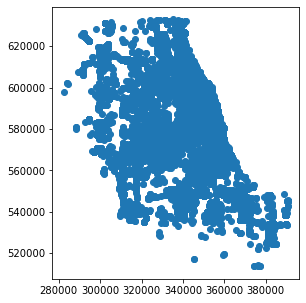

In [12]:
fig,ax=plt.subplots(figsize=(5,5))
doctors_in_buffer_gdf.plot(ax=ax)

### 2.3 Insurance plans and carriers

In [13]:
#load insurance data
insurance_df=pd.read_csv('Doctor2020/SharecareInsurance20200103_15453859.csv',sep="|")
insurance_df.drop(['insuranceId2'],axis=1,inplace=True)
insurance_df.head()

,docid,insuranceId,insuranceName,carrierId,carrierName
0,10041854,60,Humana ChoiceCare Network PPO,45,Humana
1,10041854,94,Humana National HMO,45,Humana
2,10041854,116,CIGNA PPO,26,Cigna
3,10041854,117,CIGNA Open Access Plus,26,Cigna
4,10041854,118,CIGNA HMO,26,Cigna


In [15]:
temp_df=insurance_df[['carrierId','carrierName']]
temp_df.drop_duplicates(inplace=True)
temp_df.to_csv("temp_all_us_plans.csv",index=False)

/Users/yaxiongshao/opt/miniconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [16]:
#select the insurances for doctors where locations are within the cook county buffer
doc_ins_df=  doctors_in_buffer_gdf.merge(insurance_df,left_on='id',right_on='docid')
doc_ins_df.head()

,id,npi,lat,lon,geometry,docid,insuranceId,insuranceName,carrierId,carrierName
0,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,447,Delta Dental PPO,99,Delta Dental
1,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,448,Delta Dental Premier,99,Delta Dental
2,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,571,Assurant DHA,95,Assurant
3,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,573,Ameritas PPO,94,Ameritas
4,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,574,Principal Dental PPO,133,Principal Dental


In [18]:
marketShare_df=pd.read_csv('us_insuranceMarketshare_plan_matched.csv')
marketShare_df.head()

,id,carrierName,group,marketshare,groupcode
0,9,Blue Cross of California,BLUE CROSS OF CALIFORNIA,0.0020,123470
1,143,Security Health Plan,SECURITY HLTH PLAN OF WI INC,0.0010,96881
2,124,Premier Health Plan,VIRGINIA PREMIER HLTH PLAN INC,0.0018,95612
3,151,HealthNow,HEALTH NOW NY INC,0.0023,55204
4,88,Blue Cross Blue Shield of Arizona,BCBS OF AZ INC,0.0020,53589


In [19]:
doc_ins_df= doc_ins_df.merge(marketShare_df,on="carrierName")
doc_ins_df.head()

,id_x,npi,lat,lon,geometry,docid,insuranceId,insuranceName,carrierId,carrierName,id_y,group,marketshare,groupcode
0,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,447,Delta Dental PPO,99,Delta Dental,18,OTHER,0.2443,-9999
1,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,448,Delta Dental Premier,99,Delta Dental,18,OTHER,0.2443,-9999
2,120620268,1093078735,41.9405,-88.1112,POINT (318420.338 585517.904),120620268,447,Delta Dental PPO,99,Delta Dental,18,OTHER,0.2443,-9999
3,120620268,1093078735,41.9405,-88.1112,POINT (318420.338 585517.904),120620268,448,Delta Dental Premier,99,Delta Dental,18,OTHER,0.2443,-9999
4,120620291,1366650046,41.8874,-88.3094,POINT (301986.109 579596.545),120620291,448,Delta Dental Premier,99,Delta Dental,18,OTHER,0.2443,-9999


In [20]:
doc_ins_df2=doc_ins_df.groupby(['id_x']).insuranceId.agg('count').to_frame('inscount').reset_index()
doc_ins_df2.head()

,id_x,inscount
0,4027,18
1,4040,31
2,6601,33
3,6636,27
4,10564,28


In [21]:
doc_ins_df=doc_ins_df.merge(doc_ins_df2,on='id_x')
doc_ins_df.head()

,id_x,npi,lat,lon,geometry,docid,insuranceId,insuranceName,carrierId,carrierName,id_y,group,marketshare,groupcode,inscount
0,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,447,Delta Dental PPO,99,Delta Dental,18,OTHER,0.2443,-9999,17
1,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,448,Delta Dental Premier,99,Delta Dental,18,OTHER,0.2443,-9999,17
2,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,571,Assurant DHA,95,Assurant,17,OTHER,0.2443,-9999,17
3,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,2427,Assurant DHA Premier,95,Assurant,17,OTHER,0.2443,-9999,17
4,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,573,Ameritas PPO,94,Ameritas,31,OTHER,0.2443,-9999,17


In [22]:
# compute the resources for each insurance plan
doc_ins_df["resourcescore"] = 1.0 / doc_ins_df["inscount"] 
doc_ins_df.head()

,id_x,npi,lat,lon,geometry,docid,insuranceId,insuranceName,carrierId,carrierName,id_y,group,marketshare,groupcode,inscount,resourcescore
0,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,447,Delta Dental PPO,99,Delta Dental,18,OTHER,0.2443,-9999,17,0.058824
1,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,448,Delta Dental Premier,99,Delta Dental,18,OTHER,0.2443,-9999,17,0.058824
2,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,571,Assurant DHA,95,Assurant,17,OTHER,0.2443,-9999,17,0.058824
3,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,2427,Assurant DHA Premier,95,Assurant,17,OTHER,0.2443,-9999,17,0.058824
4,120621040,1033504477,41.9361,-87.6496,POINT (356702.904 585231.501),120621040,573,Ameritas PPO,94,Ameritas,31,OTHER,0.2443,-9999,17,0.058824


In [23]:
# aggregate the resources for each doctor whose insurance plan are from the same carrier
doc_ins_df=doc_ins_df.groupby(['docid','lat','lon','group','groupcode','inscount']).resourcescore.agg('sum').to_frame('aggresourcescore').reset_index()
doc_ins_df.head(10)

,docid,lat,lon,group,groupcode,inscount,aggresourcescore
0,4027,41.8734,-87.6701,ANTHEM INC GRP,671,18,0.055556
1,4027,41.8734,-87.6701,CIGNA HLTH GRP,901,18,0.166667
2,4027,41.8734,-87.6701,CVS GRP,1,18,0.222222
3,4027,41.8734,-87.6701,HCSC GRP,917,18,0.055556
4,4027,41.8734,-87.6701,HUMANA GRP,119,18,0.111111
5,4027,41.8734,-87.6701,OTHER,-9999,18,0.166667
6,4027,41.8734,-87.6701,UNITEDHEALTH GRP,707,18,0.222222
7,4040,41.7357,-87.7220,ANTHEM INC GRP,671,31,0.032258
8,4040,41.7357,-87.7220,CIGNA HLTH GRP,901,31,0.129032
9,4040,41.7357,-87.7220,CVS GRP,1,31,0.290323


In [24]:
doc_ins_df['geometry'] = doc_ins_df.apply(lambda row: Point(row.lon, row.lat), axis=1)
doc_ins_df = gpd.GeoDataFrame(doc_ins_df,crs=('epsg:4326'))
doc_ins_df.to_crs( 'EPSG:26971',inplace=True)
doc_ins_df.head()

,docid,lat,lon,group,groupcode,inscount,aggresourcescore,geometry
0,4027,41.8734,-87.6701,ANTHEM INC GRP,671,18,0.055556,POINT (355056.671 578254.089)
1,4027,41.8734,-87.6701,CIGNA HLTH GRP,901,18,0.166667,POINT (355056.671 578254.089)
2,4027,41.8734,-87.6701,CVS GRP,1,18,0.222222,POINT (355056.671 578254.089)
3,4027,41.8734,-87.6701,HCSC GRP,917,18,0.055556,POINT (355056.671 578254.089)
4,4027,41.8734,-87.6701,HUMANA GRP,119,18,0.111111,POINT (355056.671 578254.089)


### 2.4 prepare data for spatial join

In [25]:
#read file that previously used for computing the OD matrix and get the id of the doctors location
doc_ins_df_temp=pd.read_csv('Results/cookcounty_15mi_indivuals_doc_latlon_nationalmarketshareDiffweights_7483_V16.csv')
doc_ins_df_temp.drop(["exp","doc","mar","ins"],axis=1,inplace=True)
doc_ins_df_temp['geometry'] = doc_ins_df_temp.apply(lambda row: Point(row.lon, row.lat), axis=1)
doc_ins_df_temp = gpd.GeoDataFrame(doc_ins_df_temp,crs=('epsg:4326'))
doc_ins_df_temp.to_crs( 'EPSG:26971',inplace=True)
doc_ins_df_temp.head()

,lat,lon,id,geometry
0,41.2900,-87.4447,1000,POINT (374435.086 513628.451)
1,41.2912,-87.4211,1001,POINT (376410.524 513782.230)
2,41.2913,-87.4122,1002,POINT (377155.894 513801.210)
3,41.2917,-87.4190,1003,POINT (376585.841 513839.610)
4,41.2973,-87.4213,1004,POINT (376386.659 514459.508)


In [26]:
#to get the id used in OD matrix, join these two dataframes and get the id
sjoined_listings = gpd.sjoin(doc_ins_df, doc_ins_df_temp)
sjoined_listings.drop(["index_right","lat_right","lon_right"],axis=1,inplace=True)
sjoined_listings["uid"]= sjoined_listings.index+100000
sjoined_listings.head()
#docid is the orignal id for doctor data which is unique for each doctor
#uid is the id current dataframe used to make each row unique
#id the for each location, which can be used to join with the OD matrix

,docid,lat_left,lon_left,group,groupcode,inscount,aggresourcescore,geometry,id,uid
0,4027,41.8734,-87.6701,ANTHEM INC GRP,671,18,0.055556,POINT (355056.671 578254.089),4478,100000
1,4027,41.8734,-87.6701,CIGNA HLTH GRP,901,18,0.166667,POINT (355056.671 578254.089),4478,100001
2,4027,41.8734,-87.6701,CVS GRP,1,18,0.222222,POINT (355056.671 578254.089),4478,100002
3,4027,41.8734,-87.6701,HCSC GRP,917,18,0.055556,POINT (355056.671 578254.089),4478,100003
4,4027,41.8734,-87.6701,HUMANA GRP,119,18,0.111111,POINT (355056.671 578254.089),4478,100004


In [27]:
drop_list=['group','inscount','geometry']
sjoined_listings.drop(drop_list,axis=1,inplace=True)
sjoined_listings.columns=['docid','lat','lon','groupcode','as','id','uid']
sjoined_listings.head()

,docid,lat,lon,groupcode,as,id,uid
0,4027,41.8734,-87.6701,671,0.055556,4478,100000
1,4027,41.8734,-87.6701,901,0.166667,4478,100001
2,4027,41.8734,-87.6701,1,0.222222,4478,100002
3,4027,41.8734,-87.6701,917,0.055556,4478,100003
4,4027,41.8734,-87.6701,119,0.111111,4478,100004


In [28]:
#check join result
doc_ins_df.shape,doc_ins_df_temp.shape,sjoined_listings.shape

((161717, 8), (7483, 4), (161717, 7))

In [29]:
sjoined_listings.to_csv('Results/cookcounty_15mi_indivuals_doc_latlon_byInsurace_161717_V18.csv',index=False)

In [30]:
#prepare data for comparison: number of doctors
temp=sjoined_listings[['docid','lat','lon']]
temp.drop_duplicates(inplace=True)
temp2=temp.groupby(['lat','lon'])['docid'].count().reset_index()
temp2["sid"]=temp2.index+1000
temp2.columns=['lat','lon','doc','id']
temp2.head()

/Users/yaxiongshao/opt/miniconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,lat,lon,doc,id
0,41.2900,-87.4447,2,1000
1,41.2912,-87.4211,1,1001
2,41.2913,-87.4122,2,1002
3,41.2917,-87.4190,2,1003
4,41.2973,-87.4213,1,1004


In [31]:
temp2.shape
temp2.to_csv('Results/doctor_in_buffer_15mi.csv',index=False)